# Zinvestor
## Research Factors Impacting Real Estate Assessment using Zillow data (Zestimate)

Students should also submit a final report that discusses the following:
1. A one paragraph abstract describing the project
2. The problem or hypothesis being solved
3. Applications or motivation for a good result
4. The steps taken to perform the analysis (ingestion, wrangling, computation, and
visualization).
5. A discussion of the methodology used, its quality and if it could be improved
6. A discussion of the final product (application, report, or visualization)
7. A conclusion that contains lessons learned
8. The location on Github of the code related to the project
Please ensure that you cite all sources in your final project. Please also be sure the instructor
can look at and review the code that you used to perform your analyses.

Project Goal:
Identify drivers of Zestimate error at the zip code level within Washington DC.  
Model residual of Zestimate to actual sales price within 2017. 
Covariates used to predict Zestimate error include individual property data, neighborhood demographic data, and business license data.

Hypothesis:
Real Estate values fluctuate based on local activities at zip code/neighborhood level. These local activities (esp. businesses and population demographics) highly impact Zestimate.

What is Zestimate?:
- The Zestimate® home value is Zillow's estimated market value for an individual home and is calculated for about 100 million homes nationwide. 
- It is a starting point in determining a home's value but it is not an official appraisal. 
- The Zestimate is automatically computed daily based on millions of public and user-submitted data points. 


## Data Exploration and Modeling Pipeline w/Basic Features
### Import all needed packages

## Architecture Diagram

### Data Ingestion

Zillow Property Data: 
    - Zillow APIs were initially used to obtain zillow data for properties
        - However, Zillow APIs only allow data for one property at a time based on exact physical address or Zillow Property ID (ZPID)
    - Team used Web Scrapping methodology (BeautifulSoup) to obtain ZPID for Houses for Sale in Washington DC (~11k records)
    - Used Zillow API to obtain detailed property information on each scrapped ZPID
    - Zillow limits API calls to 3000 calls per day
    - Needed to collect 6 weeks of data
    - Distributed ZPID over team members; Ran Zillow APIs calls 3 times a week for six weeks.
    - The detailed property data from API calls were stored as XML and additional challenges were encountered as we imported to CSV format
    <<<<Size of record >>>>
Open Data DC: 
    - Obtained 5 year Business License data from http://opendata.dc.gov/ as CSVs
    - Zillow Neighborhood Data: 
    - Downloaded Zillow Neighborhood data as CSVs from Zillow website
Census:
    - Developed API calls using Psycopg2 to obtain ACS data from US Census but we ended up not using this data in our analysis 

### Data Munging & Wrangling

Initially we used locally installed PostgreSQL database but soon had to move to AWS PostgreSQL so all team members can work from the same data set. 
First step was to combine primary ZPID files with CSVs from 3 team members capturing 3 CSV per week for 6 weeks 
Essentially combine 55 CSV in a single table in Postgres
Encountered challenges in data types, null values, missing Zestimate etc..
Uploaded Business License and Zillow Neighborhood data into AWS PostgreSQL and organized it by zip code.

### Computation and Analysis

In [ ]:
Created targets and features
- Over <<20 features>>
- Over <<3000>> instances from week 6
Interesting Factoid about DC Housing:
- Two housing booms
- Age of DC houses
- Average sqft before and after 2000
- Imputed null values with median? 
Uncovered some data anomalies:
- Duplicate ZPIDs
- Last Sold Date didn’t match information on Zillow website
- Huge variance in sold price vs Zestimate <<?>> 
Train / Test Hypothesis

In [427]:
import psycopg2
import pandas as pd
import pandas.io.sql as pdsql
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from pandas.tools.plotting import scatter_matrix
from sklearn import cross_validation as cv
from sklearn.cross_validation import train_test_split as tts
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, RandomizedLasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

### Connect to AWS Container

In [459]:
con=psycopg2.connect(dbname= 'DCZillow', 
                     host='dczillow.cfdlhqngxmri.us-east-1.rds.amazonaws.com',
                     port='5432',
                     user= 'DCZillow', 
                     password= 'DCZillow');

cur = con.cursor()

### Pull Table into a Data Frame
We stored all weekly data in our Postgres database. Pulling it down into a Data Frame for easier processing.
This dataset represents all properties for sale as of 7/1/2017 or those that had sold in the last 90 days.

In [460]:
df = pdsql.read_sql("""SELECT * FROM zillow_weekly""", con)
df.shape

(4690, 82)

In [462]:
# Close connection to the database
cur.close()
con.close()

### Select Only the Variables Needed for Analysis / Modeling

In [463]:
df1 = df[['bedrooms', 'bathrooms', 'yearbuilt', 'lotsizesqft', 'taxassessment_6','finishedsqft',
         'for_sale','zpid','street','city','state','zipcode',
          'zestimate_1', 'zestimate_6', 'percentile_1', 'percentile_6', 'lastsolddate_6', 'lastsoldprice_6',  
         'bedrooms_missing', 'bathrooms_missing', 'yearbuilt_missing', 'lotsizesqft_missing', 'finishedsqft_missing']]

### Treat Variables and Create Target
Some variables were pulled into the database as the incorrect type. Correcting format here.

In [464]:
df1.loc[:,'lastsolddate_6'] = pd.to_datetime(df1['lastsolddate_6'])
df1.loc[:,'bathrooms'] = pd.to_numeric(df1['bathrooms'], errors='coerse')
df1.loc[:,'lotsizesqft'] = df1['lotsizesqft'].astype(int)
df1.loc[:,'target_2017'] = abs(df1['lastsoldprice_6'] - df1['zestimate_6'])

df2 = df1.dropna(subset=['zpid'])
df2.shape


(3990, 24)

### Limit to Only homes sold in 2017
Target window is  set to measure the residual of Sale Price - Zestimate for homes sold in 2017. The Zestimate is as of mid-August. As the target window becomes closer to the snapshot date of mid-August, the number of observations for modeling is reduced.

In [473]:
df2.index = df2['lastsolddate_6']
df3=df2['1/1/2017':]
df3.head(10)

,bedrooms,bathrooms,yearbuilt,lotsizesqft,taxassessment_6,finishedsqft,for_sale,zpid,street,city,...,percentile_1,percentile_6,lastsolddate_6,lastsoldprice_6,bedrooms_missing,bathrooms_missing,yearbuilt_missing,lotsizesqft_missing,finishedsqft_missing,target_2017
lastsolddate_6,,,,,,,,,,,,,,,,,,,,,
2017-01-18,4,7.0,2010,17777,10600000.0,10897,1,1.084285e+08,2815 Woodland Dr NW,Washington,...,99.0,99.0,2017-01-18,10750000.0,0,0,0,0,0,1766512.0
2017-06-30,2,2.0,1908,565,367380.0,946,1,2.101223e+09,1 Logan Cir NW,Washington,...,0.0,0.0,2017-06-30,420000.0,0,0,0,0,0,350228.0
2017-05-12,2,2.0,1938,1552,162050.0,832,0,5.092020e+05,3427 Eads St NE,Washington,...,46.0,73.0,2017-05-12,268000.0,0,0,0,0,0,1057.0
2017-07-10,4,4.0,2017,756,523750.0,1700,1,2.093799e+09,2803 Sherman Ave NW # 2,Washington,...,0.0,0.0,2017-07-10,669000.0,0,0,0,0,0,146533.0
2017-04-05,3,1.5,1946,1999,186130.0,1998,0,5.158770e+05,4707 Bass Pl SE,Washington,...,55.0,85.0,2017-04-05,160000.0,0,0,0,0,0,170811.0
2017-05-01,2,1.0,1942,1564,435760.0,1175,0,4.473660e+05,3880 Porter St NW APT E353,Washington,...,29.0,28.0,2017-05-01,485000.0,0,0,0,0,0,8254.0
2017-01-10,2,1.0,1942,1502,162280.0,960,1,2.093810e+09,3311 Clay Pl NE # KINGMAN,Washington,...,0.0,0.0,2017-01-10,351000.0,0,0,0,0,0,75322.0
2017-04-12,3,2.0,1920,5000,219310.0,1456,0,6.807167e+07,5602 Clay Pl NE,Washington,...,68.0,74.0,2017-04-12,150000.0,0,0,0,0,0,118608.0
2017-06-05,3,2.0,1905,12000,315050.0,1802,0,5.255490e+05,2331 High St SE,Washington,...,90.0,81.0,2017-06-05,500000.0,0,0,0,0,0,119284.0


### Visualize Predictors
Determine which features need further treatment. for_sale flag is excluded because of its simple binary form.

pchange_6wk need to be treated to remove nulls before inclusion

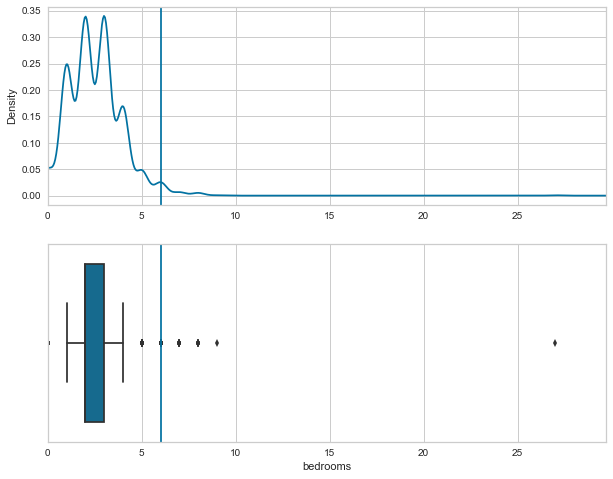

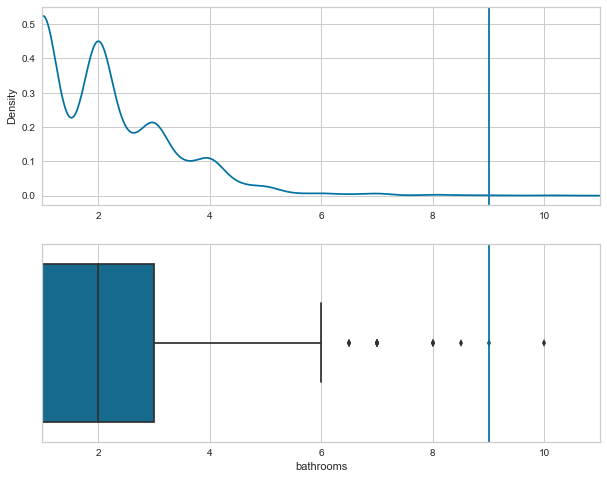

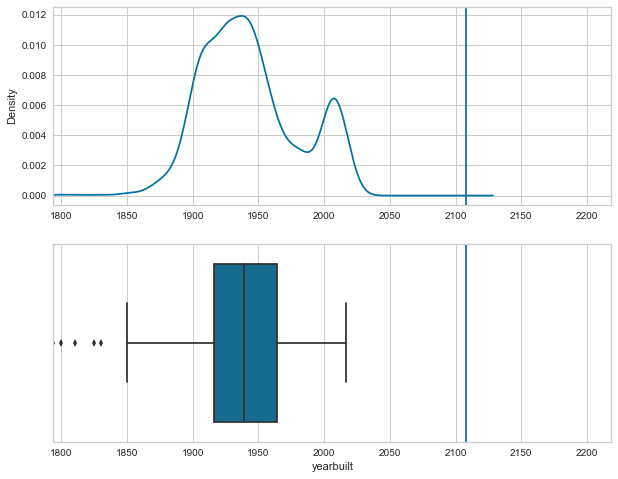

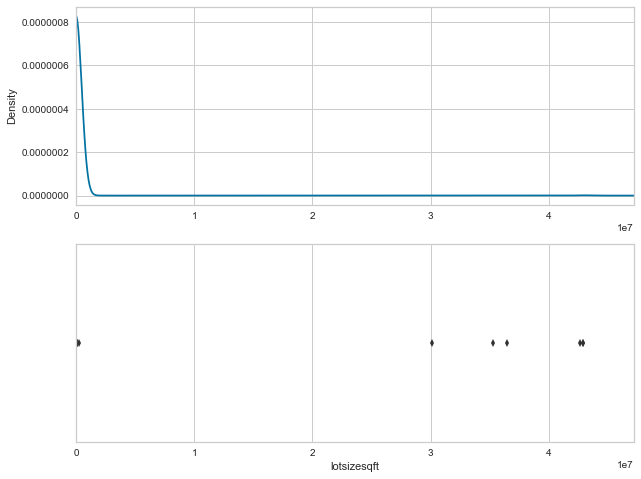

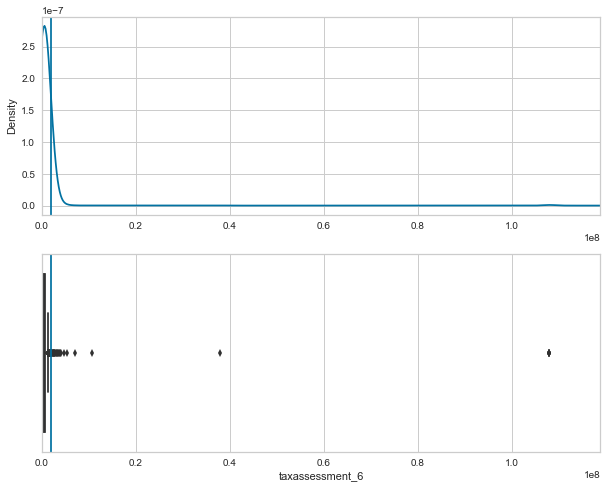

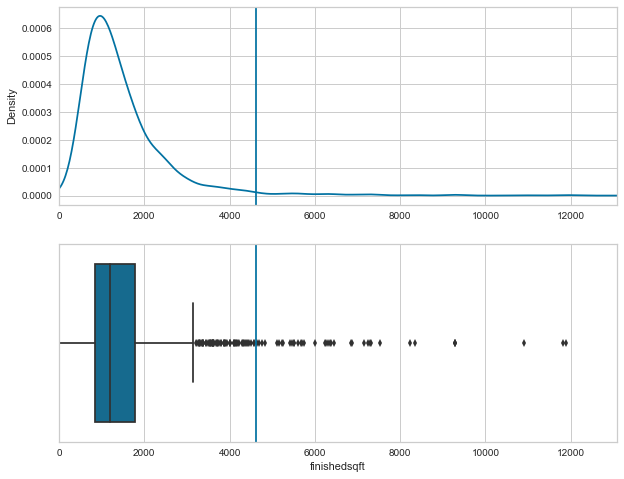

In [474]:
predictors = ['bedrooms', 'bathrooms', 'yearbuilt', 'lotsizesqft', 'taxassessment_6','finishedsqft']

for i in predictors:

#     plt.figure(figsize=(10,8))
#     plt.subplot(211)
#     plt.xlim(df3[i].min(), df3[i].max()*1.1)

#     ax = df3[i].plot(kind='kde')

#     plt.subplot(212)
#     plt.xlim(df3[i].min(), df3[i].max()*1.1)
#     sns.boxplot(x=df3[i])
#     sns.plt.show()
    
    q25, q75 = np.percentile(df3[i].dropna(), [25 ,75])
    iqr = q75 - q25

    min = q25 - (iqr*3)
    max = q75 + (iqr*3)
    
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.xlim(df3[i].min(), df3[i].max()*1.1)
    plt.axvline(x=min)
    plt.axvline(x=max)

    ax = df3[i].plot(kind='kde')

    plt.subplot(212)
    plt.xlim(df3[i].min(), df3[i].max()*1.1)
    sns.boxplot(x=df3[i])
    plt.axvline(x=min)
    plt.axvline(x=max)
    
    sns.plt.show()


## Takeaways From Basic Visual Data Analysis
#### 1. Functional form of some variables may need to be changed
lotsizesqft and taxassessment may benefit from transforming 

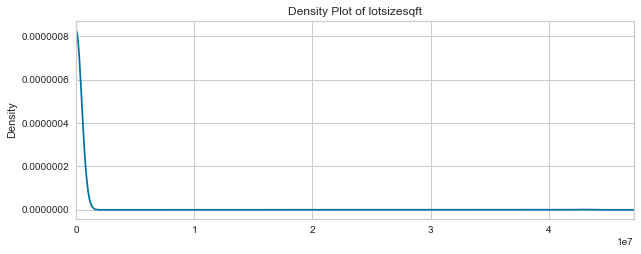

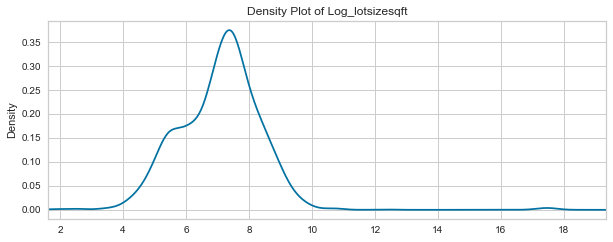

In [475]:
# Create Log of lotsizesqft

i = 'lotsizesqft'
i2 = 'Log_lotsizesqft'
df3.loc[:,'Log_'+i] = np.log(df3[i])
      
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df3[i].min(), df3[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
ax = df3[i].plot(kind='kde')
plt.title('Density Plot of lotsizesqft')

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df3[i2].min(), df3[i2].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
ax = df3[i2].plot(kind='kde')
plt.title('Density Plot of Log_lotsizesqft')

sns.plt.show()

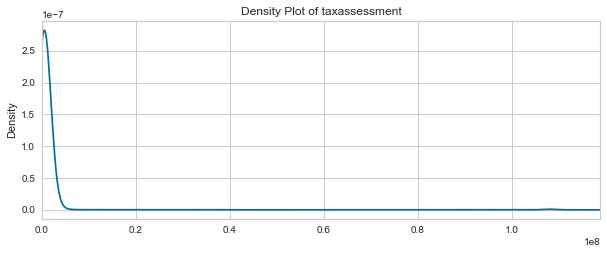

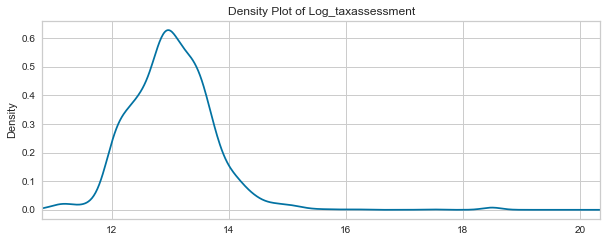

In [477]:
# Create Log of taxassessment
i = 'taxassessment_6'
i2 = 'Log_taxassessment_6'
df3.loc[:,'Log_'+i] = np.log(df3[i])
      
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df3[i].min(), df3[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
ax = df3[i].plot(kind='kde')
plt.title('Density Plot of taxassessment')

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df3[i2].min(), df3[i2].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
ax = df3[i2].plot(kind='kde')
plt.title('Density Plot of Log_taxassessment')

sns.plt.show()

#### 2. Most fields have extreme values that need to be treated
Cap at 99th percentile

In [478]:
qmax = df3['bedrooms'].quantile(0.99) 
df3[df3['bedrooms'] < qmax] 

qmax = df3['bathrooms'].quantile(0.99) 
df3[df3['bathrooms'] < qmax] 

qmax = df3['Log_lotsizesqft'].quantile(0.99) 
df3[df3['Log_lotsizesqft'] < qmax] 

qmax = df3['Log_taxassessment_6'].quantile(0.99) 
df3[df3['Log_taxassessment_6'] < qmax] 

qmax = df3['finishedsqft'].quantile(0.99) 
df3[df3['finishedsqft'] < qmax] 
    

,bedrooms,bathrooms,yearbuilt,lotsizesqft,taxassessment_6,finishedsqft,for_sale,zpid,street,city,...,lastsolddate_6,lastsoldprice_6,bedrooms_missing,bathrooms_missing,yearbuilt_missing,lotsizesqft_missing,finishedsqft_missing,target_2017,Log_lotsizesqft,Log_taxassessment_6
lastsolddate_6,,,,,,,,,,,,,,,,,,,,,
2017-06-30,2,2.00,1908,565,367380.0,946,1,2.101223e+09,1 Logan Cir NW,Washington,...,2017-06-30,420000.0,0,0,0,0,0,350228.0,6.336826,12.814152
2017-05-12,2,2.00,1938,1552,162050.0,832,0,5.092020e+05,3427 Eads St NE,Washington,...,2017-05-12,268000.0,0,0,0,0,0,1057.0,7.347300,11.995660
2017-07-10,4,4.00,2017,756,523750.0,1700,1,2.093799e+09,2803 Sherman Ave NW # 2,Washington,...,2017-07-10,669000.0,0,0,0,0,0,146533.0,6.628041,13.168770
2017-04-05,3,1.50,1946,1999,186130.0,1998,0,5.158770e+05,4707 Bass Pl SE,Washington,...,2017-04-05,160000.0,0,0,0,0,0,170811.0,7.600402,12.134201
2017-05-01,2,1.00,1942,1564,435760.0,1175,0,4.473660e+05,3880 Porter St NW APT E353,Washington,...,2017-05-01,485000.0,0,0,0,0,0,8254.0,7.355002,12.984847
2017-01-10,2,1.00,1942,1502,162280.0,960,1,2.093810e+09,3311 Clay Pl NE # KINGMAN,Washington,...,2017-01-10,351000.0,0,0,0,0,0,75322.0,7.314553,11.997079
2017-04-12,3,2.00,1920,5000,219310.0,1456,0,6.807167e+07,5602 Clay Pl NE,Washington,...,2017-04-12,150000.0,0,0,0,0,0,118608.0,8.517193,12.298242
2017-06-05,3,2.00,1905,12000,315050.0,1802,0,5.255490e+05,2331 High St SE,Washington,...,2017-06-05,500000.0,0,0,0,0,0,119284.0,9.392662,12.660487
2017-04-21,3,4.00,1927,3519,911010.0,2500,0,4.480960e+05,3815 Warren St NW,Washington,...,2017-04-21,153000.0,0,0,0,0,0,1010344.0,8.165932,13.722309


#### 2. Variables with Multimodal distributions need to be assessed more closely
Yearbuilt illustrates two peaks of building in DC are between 1900 and 1950 and shortly after 2000. May be a case to derive variable or interaction to better differentiate the effect.

/Users/gbq483/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


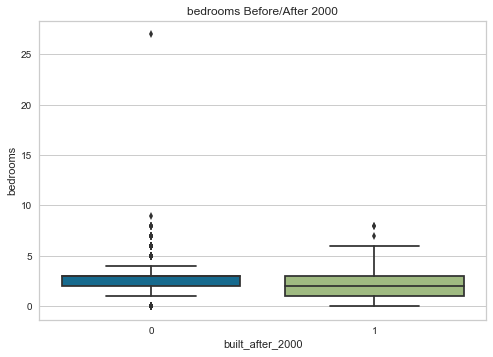

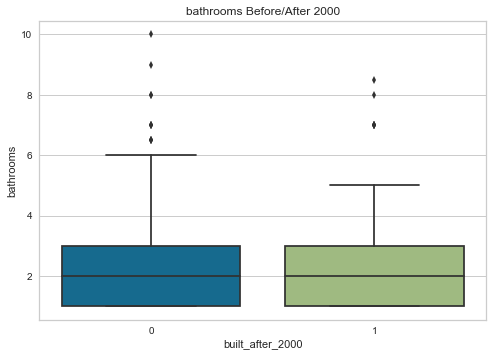

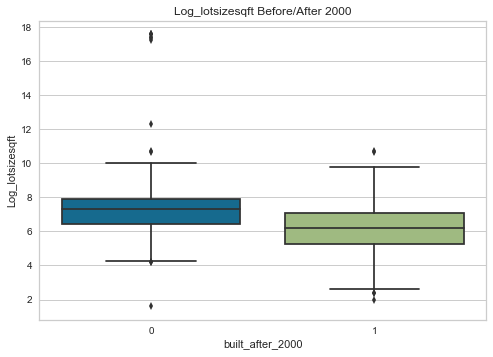

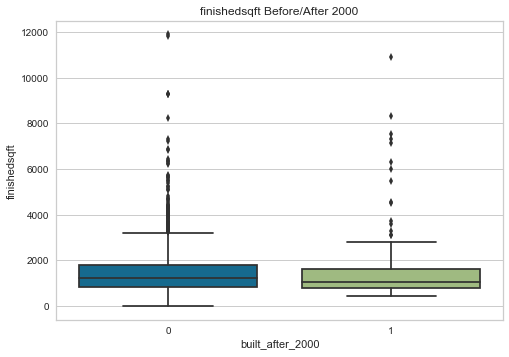

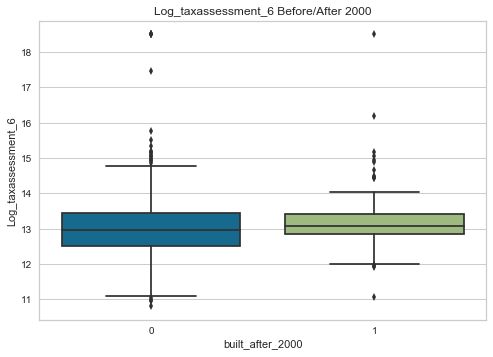

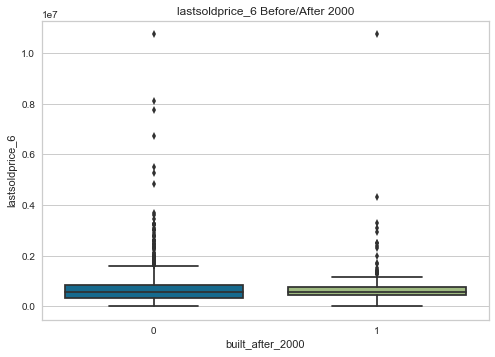

In [479]:
df3['built_after_2000'] = df3['yearbuilt'] > 2000
df3.loc[:,'built_after_2000'] = df3['built_after_2000'].astype(int)

g = sns.boxplot(y='bedrooms', x='built_after_2000', data=df3)
t = g.set_title("bedrooms Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='bathrooms', x='built_after_2000', data=df3)
t = g.set_title("bathrooms Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='Log_lotsizesqft', x='built_after_2000', data=df3)
t = g.set_title("Log_lotsizesqft Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='finishedsqft', x='built_after_2000', data=df3)
t = g.set_title("finishedsqft Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='Log_taxassessment_6', x='built_after_2000', data=df3)
t = g.set_title("Log_taxassessment_6 Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='lastsoldprice_6', x='built_after_2000', data=df3)
t = g.set_title("lastsoldprice_6 Before/After 2000")
sns.plt.show()


In [481]:
# Impute null pchange to median
medbedrooms = np.median(df3.bedrooms)   
df3.bedrooms = df3.bedrooms.fillna(medbedrooms)

medbathrooms = np.median(df3.bathrooms)   
df3.bathrooms = df3.bathrooms.fillna(medbathrooms)

medLog_lotsizesqft = np.median(df3.Log_lotsizesqft)   
df3.Log_lotsizesqft = df3.Log_lotsizesqft.fillna(medLog_lotsizesqft)

medLog_taxassessment_6 = np.median(df3.Log_taxassessment_6)   
df3.Log_taxassessment_6 = df3.Log_taxassessment_6.fillna(medLog_taxassessment_6)

medfinishedsqft = np.median(df3.finishedsqft)   
df3.finishedsqft = df3.finishedsqft.fillna(medfinishedsqft)

medfor_sale = np.median(df3.for_sale)   
df3.for_sale = df3.for_sale.fillna(medfor_sale)

medyearbuilt = np.median(df3.yearbuilt)   
df3.yearbuilt = df3.yearbuilt.fillna(medyearbuilt)

medbuilt_after_2000 = np.median(df3.built_after_2000)   
df3.built_after_2000 = df3.built_after_2000.fillna(medbuilt_after_2000)


In [482]:
# Create indicators for property size
df3.loc[:,'sqft_lt1000'] = df3['finishedsqft'] < 1000
df3.loc[:,'sqft_lt1000'] = df3['sqft_lt1000'].astype(int)

df3.loc[:,'sqft_lt1500'] = df3['finishedsqft'] < 1500
df3.loc[:,'sqft_lt1500'] = df3['sqft_lt1500'].astype(int)

df3.loc[:,'sqft_lt2000'] = df3['finishedsqft'] < 2000
df3.loc[:,'sqft_lt2000'] = df3['sqft_lt2000'].astype(int)

df3.loc[:,'sqft_lt2500'] = df3['finishedsqft'] < 2500
df3.loc[:,'sqft_lt2500'] = df3['sqft_lt2500'].astype(int)

df3.loc[:,'sqft_ge2500'] = df3['finishedsqft'] >= 2500
df3.loc[:,'sqft_ge2500'] = df3['sqft_ge2500'].astype(int)

### Plot predictors against the target

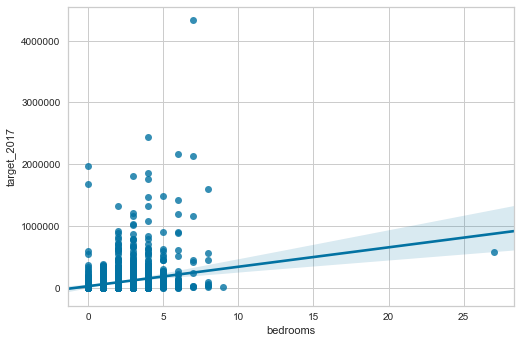

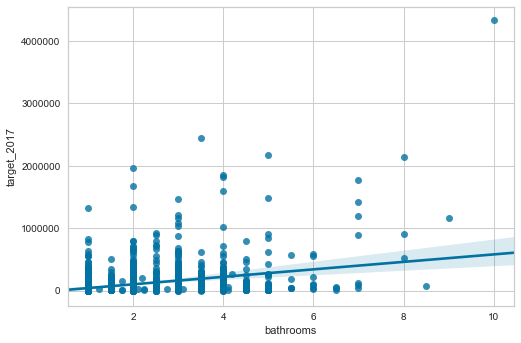

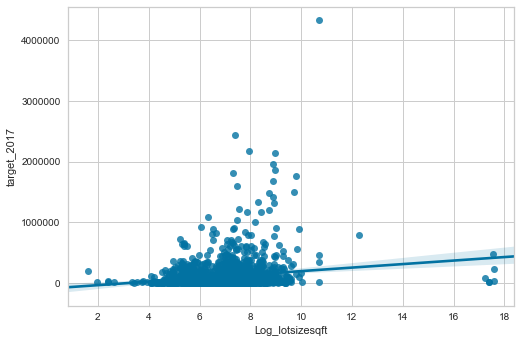

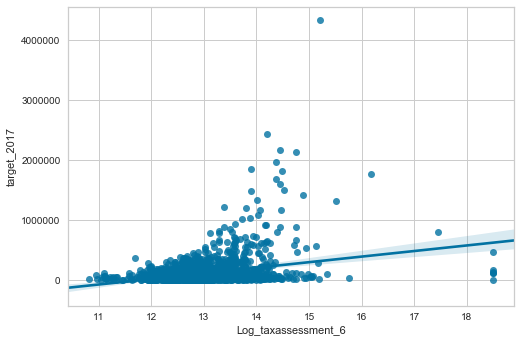

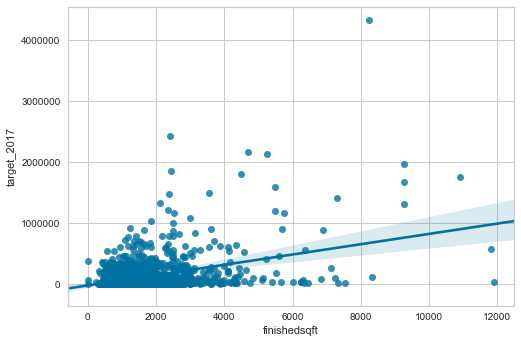

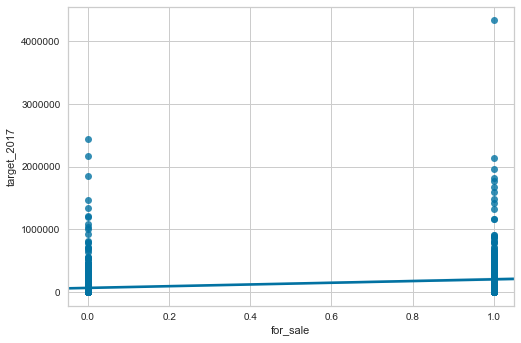

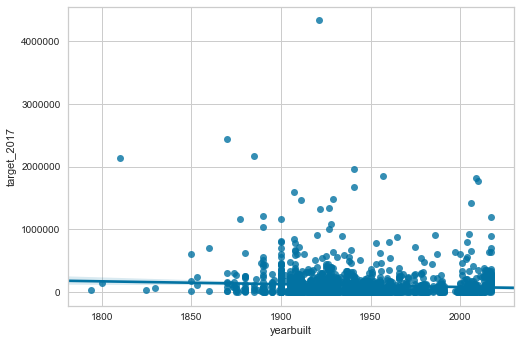

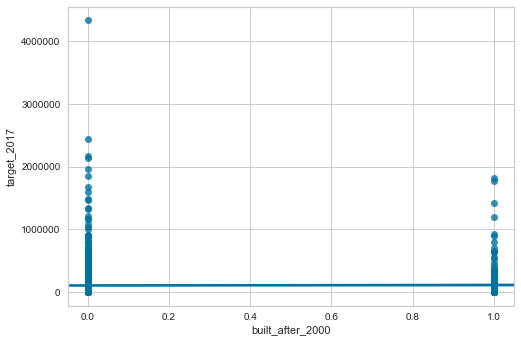

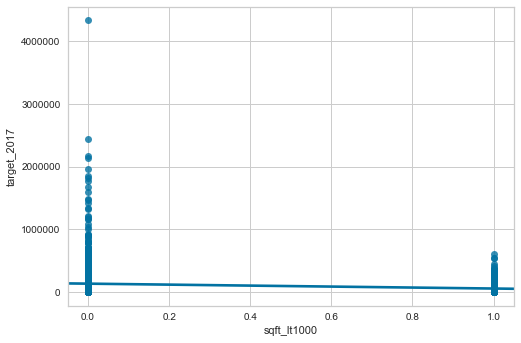

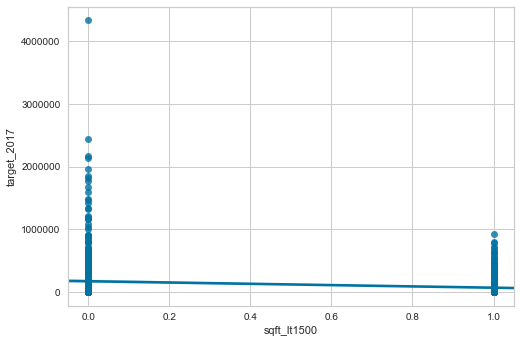

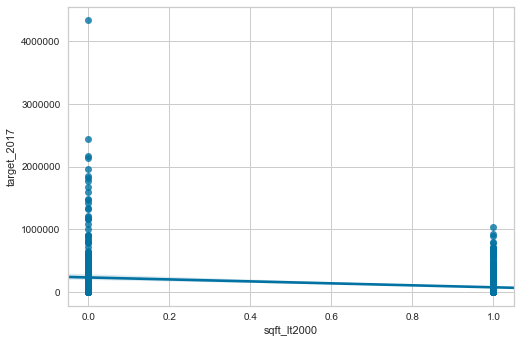

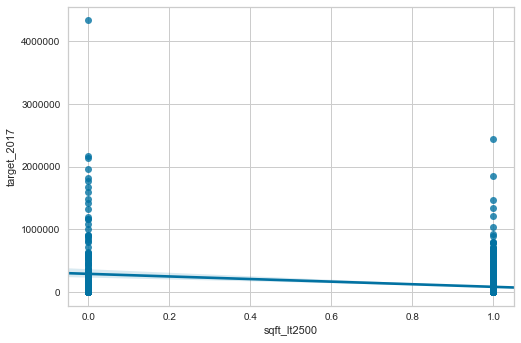

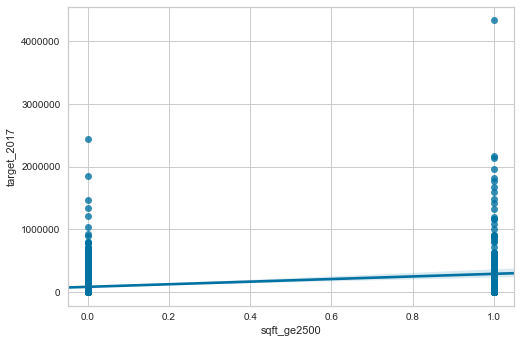

In [483]:
g = sns.regplot(x="bedrooms", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="bathrooms", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="Log_lotsizesqft", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="Log_taxassessment_6", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="finishedsqft", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="for_sale", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="yearbuilt", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="built_after_2000", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_lt1000", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_lt1500", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_lt2000", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_lt2500", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_ge2500", y="target_2017", data=df3)
sns.plt.show()


### Correlation of Predictors
#### Bedrooms and Bathrooms are correlated; Sqft, bedrooms, and bathrooms are correlated; all missing inds are correlated

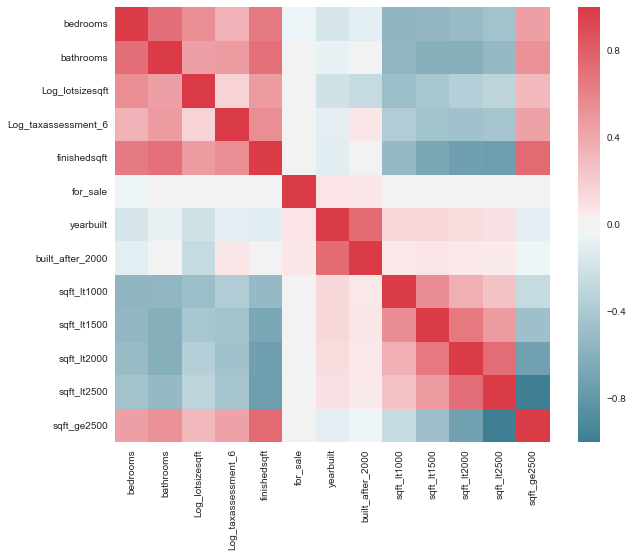

In [485]:
features = df3[['bedrooms', 'bathrooms', 'Log_lotsizesqft', 'Log_taxassessment_6','finishedsqft',  
             'for_sale', 'yearbuilt', 'built_after_2000', 'sqft_lt1000', 'sqft_lt1500', 'sqft_lt2000', 'sqft_lt2500', 'sqft_ge2500']]

target = df3[['target_2017']]

f, ax = plt.subplots(figsize=(10, 8))
corr = features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
sns.plt.show()

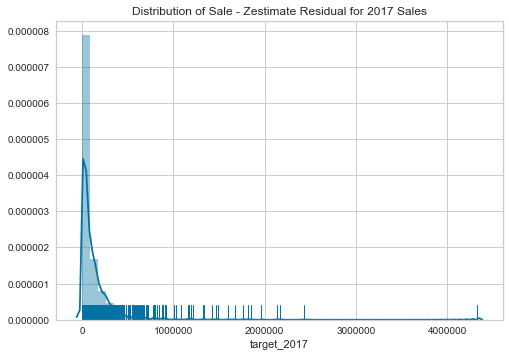

In [486]:
g = sns.distplot(target.target_2017, rug=True, kde=True)
t = g.set_title("Distribution of Sale - Zestimate Residual for 2017 Sales")
sns.plt.show()

In [487]:
features.describe()

,bedrooms,bathrooms,Log_lotsizesqft,Log_taxassessment_6,finishedsqft,for_sale,yearbuilt,built_after_2000,sqft_lt1000,sqft_lt1500,sqft_lt2000,sqft_lt2500,sqft_ge2500
count,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000
mean,2.531859,2.135887,7.073560,13.023037,1500.259610,0.286467,1943.530806,0.148499,0.355977,0.644550,0.806740,0.888889,0.111111
std,1.489129,1.180729,1.348048,0.734481,1107.526906,0.452229,37.126453,0.355688,0.478934,0.478776,0.394959,0.314352,0.314352
min,0.000000,1.000000,1.609438,10.809324,1.000000,0.000000,1794.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,6.215607,12.549057,832.500000,0.000000,1916.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,2.000000,2.000000,7.190676,12.991206,1200.000000,0.000000,1939.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,3.000000,7.832808,13.431009,1778.000000,1.000000,1964.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,27.000000,10.000000,17.574536,18.497642,11898.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [488]:
target.describe()

,target_2017
count,1.899000e+03
mean,1.076379e+05
std,2.289581e+05
min,1.100000e+01
25%,9.135000e+03
50%,3.141400e+04
75%,1.213580e+05
max,4.327673e+06


In [489]:
model = RandomizedLasso(alpha=0.05)
model.fit(features, target["target_2017"])
names = list(features)

print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), model.scores_), 
                 names), reverse=True))

Features sorted by their score:
[(1.0, 'finishedsqft'), (0.995, 'Log_taxassessment_6'), (0.985, 'for_sale'), (0.98, 'yearbuilt'), (0.98, 'bathrooms'), (0.975, 'sqft_lt1500'), (0.975, 'bedrooms'), (0.97, 'built_after_2000'), (0.965, 'sqft_lt2000'), (0.96, 'sqft_lt1000'), (0.95, 'Log_lotsizesqft'), (0.515, 'sqft_ge2500'), (0.485, 'sqft_lt2500')]


### Create Train / Test Split and Assess Basic Models

In [497]:
splits = cv.train_test_split(features, target, test_size=0.2)
X_train, X_test, y_train, y_test = splits
X_train.shape, y_train.shape


((1519, 13), (1519, 1))

In [498]:
X_test.shape, y_test.shape

((380, 13), (380, 1))

In [499]:
# Create a ridge regression object: ridge
ridge = Ridge().fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = ridge.predict(X_test)

print('Ridge Model')
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(y_test, y_pred))))
print('Mean Squared Error: {:.3f}'.format(mse(y_test, y_pred)))
print('Coefficient of Determination: {:.3f}'.format(r2_score(y_test, y_pred)))

Ridge Model
Root Mean Squared Error: 225206.546
Mean Squared Error: 50717988297.868
Coefficient of Determination: 0.296


In [501]:
print('ridge.coef_: {}'.format(ridge.coef_))
print('ridge.intercept_: {}'.format(ridge.intercept_))

ridge.coef_: [[ -1.15428011e+04   2.18146341e+04   1.14787529e+03   3.49887891e+04
    7.23521806e+01   1.25596096e+05  -7.05454566e+02   4.87051470e+04
    2.68182350e+04   2.52841870e+04  -1.17278351e+04   1.70605456e+04
   -1.70605456e+04]]
ridge.intercept_: [ 816926.92861282]


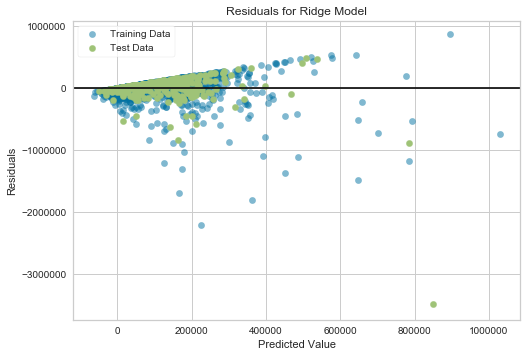

In [504]:
visualizer = ResidualsPlot(ridge)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof() 

In [506]:
model = LinearRegression()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print("Linear Regression model")
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(expected, predicted))))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

Linear Regression model
Root Mean Squared Error: 225188.272
Coefficient of Determination: 0.296


In [507]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print("Random Forest model")
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(expected, predicted))))
print("R2 score = %0.3f" % r2_score(expected, predicted))

Random Forest model
Root Mean Squared Error: 228402.476
R2 score = 0.276


/Users/gbq483/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Next Steps:
Further test hypothesis using additional:
- Data Sources:
    - Add Census data
    - Zillow Neighborhood Data
    - Other Geographies
- More granular analysis based on lat/long
- Refined time window
- Use Zillow’s Kaggle Data Set for two counties in California
- Potential Real Estate Investor application

### GitHub Code Repository:
https://github.com/IoTDevPro/RealEstateMoguls